In [70]:

# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt
import mne_nirs
import mne



# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm, statsmodels_to_results
from nilearn.plotting import plot_design_matrix
from mne.annotations import Annotations
from statsmodels.formula.api import mixedlm


from scipy.stats import ttest_ind


# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


# import summary_df from csv file
summary_df = pd.read_csv("global_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore_nocrop.csv")
stats_df = pd.read_csv("individual_mean_stddev_zscore_negcorr.csv")


# Preprocessing

## Epoch rejection

In [71]:
def reject_epochs(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0):
    """
    Rejects epochs based on z-score threshold using subject/session/condition-specific stats from stats_df.

    Parameters:
        data (ndarray): (n_epochs,) or (n_epochs, n_times) – mean amplitude per epoch
        subject (str): e.g., "01"
        session (str): e.g., "01"
        condition_name (str): "Control", "Noise", or "Speech"
        stats_df (pd.DataFrame): DataFrame with per-participant mean and std
        z_thresh (float): Z-score threshold
        max_reject_ratio (float): Max proportion of epochs to reject

    Returns:
        cleaned_data (ndarray), {
            "CONDITION_GOOD_IDX": [...],
            "CONDITION_BAD_IDX": [...]
        }
    """

    # Extract stats
    row = stats_df[
        (stats_df["Subject"] == f"sub-{subject}") &
        (stats_df["Session"] == f"ses-{session}") &
        (stats_df["Condition"] == condition_name)
    ]

    if row.empty:
        raise ValueError(f"No stats found for sub-{subject}, ses-{session}, {condition_name}")

    mean_val = row["Mean_Amplitude"].values[0]
    std_val = row["SD_Amplitude"].values[0]

    # Ensure data is 1D
    if data.ndim > 1:
        data = data.mean(axis=1)

    # Compute z-scores and rejection mask
    z_scores = (data - mean_val) / std_val
    reject_mask = np.abs(z_scores) > z_thresh
    rejected_indices = np.where(reject_mask)[0].tolist()

    # Enforce max rejection ratio
    max_allowed = int(max_reject_ratio * data.shape[0])
    if len(rejected_indices) > max_allowed:
        rejected_indices = rejected_indices[:max_allowed]

    # Determine kept indices
    all_indices = set(range(data.shape[0]))
    good_indices = sorted(list(all_indices - set(rejected_indices)))
    bad_indices = sorted(rejected_indices)

    # Clean the data
    cleaned_data = np.delete(data, rejected_indices, axis=0)

    # Construct keys
    condition_upper = condition_name.upper()
    good_key = f"{condition_upper}_GOOD_IDX"
    bad_key = f"{condition_upper}_BAD_IDX"

    return cleaned_data, {
        good_key: good_indices,
        bad_key: bad_indices
    }


## Full preprocessing + GLM

In [74]:
# cropping the signal before sci calculation
def preprocessing_glm_ROI(bids_path, subject_id, session_id, id, apply_epoch_rejection=True):
    print(f"Processing subject {subject_id} session {session_id}...")
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity.annotations.set_durations({'Control' : 5, 'Noise' : 5, 'Speech' : 5.25})
    
    # Get the events locations
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    ControlEvents, _ = mne.events_from_annotations(raw_intensity, {'Control': 1})
    NoiseEvents, _ = mne.events_from_annotations(raw_intensity, {'Noise': 2})
    SpeechEvents, _ = mne.events_from_annotations(raw_intensity, {'Speech': 3})
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']

    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")

    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]

    # Cropping dataset
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))

    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")

    raw_intensity_cropped = cropped_intensity.copy()

    # Remove break annotations
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])

    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)

    # get the total number of short channels
    short_chs = get_short_channels(raw_od)
    tot_number_of_short_channels = len(short_chs.ch_names)

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.7, h_freq=1.45)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.8))

    if len(bad_channels) > 55:
        print(f"❌ Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None

    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels

    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)

    # Get long channels
    long_chs = get_long_channels(raw_od)
    bad_long_chs = long_chs.info["bads"]

    len_bad_short_chs = len(bad_channels) - len(bad_long_chs)
    num_good_short_channels = tot_number_of_short_channels - len_bad_short_chs

    if num_good_short_channels < 4:
        print("❌ No short channels found. Skipping the subject.")
        return None, None, None, None, None
    else:
        # lets not include the short channels in the raw_od
        raw_od_corrected = short_channel_regression(raw_od)
        
        # raw_od_corrected = raw_od.copy()


    # Convert to haemoglobin and filter
    raw_haemo_bef = beer_lambert_law(raw_od_corrected, ppf=0.1)
    raw_haemo_bef = get_long_channels(raw_haemo_bef, min_dist=0.02)
    
    # negative correlation enhancement
    raw_haemo_bef = enhance_negative_correlation(raw_haemo_bef)

    
     
    raw_haemo_bef = raw_haemo_bef.filter(l_freq=None, h_freq=0.2, method="iir", iir_params=dict(order=5, ftype='butter'))
    raw_haemo_bef = raw_haemo_bef.filter(l_freq=0.05, h_freq=None, method="iir", iir_params=dict(order=5, ftype='butter'))
    
    
    # EPOCH REJECTION
    if apply_epoch_rejection:
        all_events, all_event_dict = mne.events_from_annotations(raw_haemo_bef)
        epochs = mne.Epochs(
            raw_haemo_bef,
            all_events,
            event_id=all_event_dict,
            tmin=-3,
            tmax=14,
            reject=dict(hbo=100e-6),
            reject_by_annotation=True,
            proj=True,
            baseline=(None, 0),
            detrend=1,
            preload=True,
            verbose=None,
        )
        
        """ evoked_dict = {
            "Noise/HbO": epochs["Noise"].average(picks="hbo"),
            "Noise/HbR": epochs["Noise"].average(picks="hbr"),
            "Control/HbO": epochs["Control"].average(picks="hbo"),
            "Control/HbR": epochs["Control"].average(picks="hbr"),
        }

        # Rename channels until the encoding of frequency in ch_name is fixed
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4])

        color_dict = dict(HbO="#AA3377", HbR="b")
        styles_dict = dict(Control=dict(linestyle="dashed"))

        mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
        ) """

        bad_ch = epochs.info['bads']
        epochs.drop_channels(bad_ch)
        hbo_data = epochs.copy().pick("hbo")
        #data = hbo_data.get_data(tmin=0, tmax=10).mean(axis=1)
        data = hbo_data.get_data().mean(axis=1)
        
        ev = epochs.events[:, 2]
        index_column = np.arange(0, len(ev)).reshape(-1, 1)
        updated_matrix = np.hstack((index_column, ev.reshape(-1, 1)))

        #time_slice = data[:, :, 26:105]
        mean_values = np.mean(data, axis=1)
        

        control_idx = updated_matrix[updated_matrix[:, 1] == 1][:, 0]
        noise_idx = updated_matrix[updated_matrix[:, 1] == 2][:, 0]
        speech_idx = updated_matrix[updated_matrix[:, 1] == 3][:, 0]

        control_mean = mean_values[control_idx]
        noise_mean = mean_values[noise_idx]
        speech_mean = mean_values[speech_idx]

        
        #  reject_epochs(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0)
        
        cleaned_data, idx_dict = reject_epochs(
            data=control_mean,
            subject=subject_id,
            session=session_id,
            condition_name="Control",
            stats_df=stats_df,
            z_thresh=2,
            max_reject_ratio=1
        )
       
        CONTROL_GOOD_IDX = idx_dict["CONTROL_GOOD_IDX"]
        CONTROL_BAD_IDX = idx_dict["CONTROL_BAD_IDX"]
        
        cleaned_data, idx_dict = reject_epochs(
            data=noise_mean,
            subject=subject_id,
            session=session_id,
            condition_name="Noise",
            stats_df=stats_df,
            z_thresh=2,
            max_reject_ratio=1
        )
        NOISE_GOOD_IDX = idx_dict["NOISE_GOOD_IDX"]
        NOISE_BAD_IDX = idx_dict["NOISE_BAD_IDX"]
        
        cleaned_data, idx_dict = reject_epochs(
            data=speech_mean,
            subject=subject_id,
            session=session_id,
            condition_name="Speech",
            stats_df=stats_df,
            z_thresh=2,
            max_reject_ratio=1
        )
        
        SPEECH_GOOD_IDX = idx_dict["SPEECH_GOOD_IDX"]
        SPEECH_BAD_IDX = idx_dict["SPEECH_BAD_IDX"]
        
        print(f"Number of rejected Control epochs: {len(CONTROL_BAD_IDX)}")
        print(f"Number of rejected Noise epochs: {len(NOISE_BAD_IDX)}")
        print(f"Number of rejected Speech epochs: {len(SPEECH_BAD_IDX)}")

        raw_haemo = raw_haemo_bef.copy()

        ControlEvents_good = ControlEvents[CONTROL_GOOD_IDX]
        onsets_control = raw_haemo.times[ControlEvents_good[:, 0]]
        durations_control = [0] * len(onsets_control)
        descriptions_control = ['Control'] * len(onsets_control)
        good_annotations_control = Annotations(onset=onsets_control, duration=durations_control, description=descriptions_control)

        NoiseEvents_good = NoiseEvents[NOISE_GOOD_IDX]
        onsets_noise = raw_haemo.times[NoiseEvents_good[:, 0]]
        durations_noise = [0] * len(onsets_noise)
        descriptions_noise = ['Noise'] * len(onsets_noise)
        good_annotations_noise = Annotations(onset=onsets_noise, duration=durations_noise, description=descriptions_noise)

        SpeechEvents_good = SpeechEvents[SPEECH_GOOD_IDX]
        onsets_speech = raw_haemo.times[SpeechEvents_good[:, 0]]
        durations_speech = [0] * len(onsets_speech)
        descriptions_speech = ['Speech'] * len(onsets_speech)
        good_annotations_speech = Annotations(onset=onsets_speech, duration=durations_speech, description=descriptions_speech)

        combined_annotations = good_annotations_control + good_annotations_noise + good_annotations_speech
        raw_haemo.set_annotations(combined_annotations)
    else:
        
        raw_haemo = raw_haemo_bef.copy()

    # make that raw_heamo only have hbo channels
    #raw_haemo= raw_haemo.pick("hbo")
    events, event_dict = mne.events_from_annotations(raw_haemo)
    isis, names = mne_nirs.experimental_design.longest_inter_annotation_interval(raw_haemo)
    design_matrix = make_first_level_design_matrix(
        raw_haemo,
        drift_model='cosine',
        high_pass=1/(2*max(isis)),
        hrf_model='spm',
        stim_dur=5.125
    )
    
    
    
    
    glm_est = run_glm(raw_haemo, design_matrix)

      
    # Define ROI channel pairs
    left = [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]]
    right = [[10, 9], [10, 10], [10, 11], [10, 12], [11, 11], [11, 12]]
    back = [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]] 
    front = [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]]
    speech_glm= [[11, 11], [11, 12], [4, 2], [4, 3], [7, 7]]
    noise_glm=[[11, 11]] 
    noise_waa= [[10, 11], [11, 11], [10, 9]]
    speech_waa= [[10, 10], [10, 11], [10, 12], [10, 9], [11, 11], [11, 12], [5,4]]
    
    '''rois = {
    "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
    "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
    "Noise_GLM": ["S11_D11 hbo"],
    "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S4_D2 hbo", "S4_D3 hbo", "S7_D7 hbo"],
    
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
    }'''
   
    

    # Generate index picks for each ROI
    roi_picks = dict(
        Left= picks_pair_to_idx(raw_haemo, left, on_missing="ignore"),
        Right= picks_pair_to_idx(raw_haemo, right, on_missing="ignore"),
        Back= picks_pair_to_idx(raw_haemo, back, on_missing="ignore"),
        Front= picks_pair_to_idx(raw_haemo, front, on_missing="ignore"),
        Speech_glm= picks_pair_to_idx(raw_haemo, speech_glm, on_missing="ignore"),
        Noise_glm= picks_pair_to_idx(raw_haemo, noise_glm, on_missing="ignore"),
        Noise_waa= picks_pair_to_idx(raw_haemo, noise_waa, on_missing="ignore"),
        Speech_waa= picks_pair_to_idx(raw_haemo, speech_waa, on_missing="ignore")    
    )
   
    
    cha= glm_est.to_dataframe()
    
    roi= glm_est.to_dataframe_region_of_interest(
        roi_picks, design_matrix.columns, demographic_info=True
    )
    
    # Define left vs right tapping contrast
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict(
        [(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)]
    )
    contrast_LvR_n = basic_conts["Noise"] - basic_conts["Control"]
    contrast_LvR_s = basic_conts["Speech"] - basic_conts["Control"]

    # Compute defined contrast
    contrast_n = glm_est.compute_contrast(contrast_LvR_n)
    contrast_s = glm_est.compute_contrast(contrast_LvR_s)
    con_n = contrast_n.to_dataframe()
    con_s = contrast_s.to_dataframe()

    # Add the participant sub to the dataframes
    roi["ID"] = cha["ID"] = con_n["ID"] = con_s["ID"] = id
    
    roi["Subject"] = cha["Subject"] = con_n["Subject"] = con_s["Subject"] = subject_id
    
    # Add the session to the dataframes
    roi["session"] = cha["session"] = con_n["session"] = con_s["session"] = session_id

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.0e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.0e6 for t in roi["theta"]]
    con_n["effect"] = [t * 1.0e6 for t in con_n["effect"]]
    con_s["effect"] = [t * 1.0e6 for t in con_s["effect"]]
    
    
    
    return raw_haemo, roi, cha, con_n, con_s
    

In [75]:

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
#subject_list = subject_list[:1]  # Limit to first 3 subjects for testing

print("Detected subjects:", subject_list)
subjects_df = pd.DataFrame(columns=["subject", "session"])




#optode_subject_sessions = {optode: pd.DataFrame(columns=["subject", "session"]) for optode in optodes}

df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con_noise = pd.DataFrame()  # To store channel level contrast results
df_con_speech = pd.DataFrame()  # To store channel level contrast results
id = 0
# Loop through subjects and sessions
for sub in subject_list:
    for ses in range(1, 3):
        
        bids_path = BIDSPath(
                subject=f"{sub}",
                session=f"{ses:02d}",
                task="auditory",
                datatype="nirs",
                root=bids_root,
                suffix="nirs",
                extension=".snirf",
            )
            
        raw_haemo, roi, cha, con_n, con_s = preprocessing_glm_ROI(bids_path, sub, f"{ses:02d}", id, apply_epoch_rejection=True)
        if raw_haemo is None:
            print(f"⚠️ No data for Subject {sub}, Session {ses:02d}. Skipping...")
            continue
        else:
            
            # Append individual results to all participants
            df_roi = pd.concat([df_roi, roi], ignore_index=True)
            df_cha = pd.concat([df_cha, cha], ignore_index=True)
            df_con_noise = pd.concat([df_con_noise, con_n], ignore_index=True)
            df_con_speech = pd.concat([df_con_speech, con_s], ignore_index=True)
            id= id + 1
                
# add a column to df_cha with the channel names without the "hbo" or "hbr" suffix
df_cha["Optode"] = df_cha["ch_name"].str.replace(" hbo", "").str.replace(" hbr", "")


Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Processing subject 01 session 01...
Number of rejected Control epochs: 1
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 1
Processing subject 01 session 02...
Number of rejected Control epochs: 2
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 1
Processing subject 02 session 01...
Number of rejected Control epochs: 1
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 02 session 02...
Number of rejected Control epochs: 1
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 03 session 01...
Number of rejected Control epochs: 0
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 03 session 02...
Number of rejected Control epochs: 0
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 0

In [78]:
df_cha.columns

Index(['Condition', 'df', 'mse', 'p_value', 'se', 't', 'theta', 'Source',
       'Detector', 'Chroma', 'Significant', 'ch_name', 'ID', 'Subject',
       'session', 'Optode'],
      dtype='object', name='variable')

In [82]:
# create a new df with the columns "Subject", "session", "Optode", "theta", "pval", "effect"
df_cha_ICC = df_cha[["ID","Subject", "session", "Optode", 'Chroma',  "Condition", "theta"]].copy()
df_cha_ICC = df_cha_ICC.query("Condition in ['Control', 'Noise', 'Speech']")
# save df to csv
df_cha_ICC.to_csv("all_subjects_evoked_values_optodes.csv", index=False)

# GLM Data-driven ROIs Construction
Single Optode Significance Analysis

In [58]:
def run_lme_per_session(df_cha, session_label):
    df_cha_q = df_cha.query("Condition in ['Control', 'Noise', 'Speech']")
    subset_session = df_cha_q[(df_cha_q["Chroma"] == "hbo") & (df_cha_q["session"] == session_label)]
    optodes = subset_session["Optode"].unique()
    #print(optodes)
    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["Subject"].nunique() < 2:
            print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("theta ~ Condition", data=subset, groups=subset["Subject"])
            result = model.fit(method="nm")
            #print(result.summary())

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["Subject"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt} (Session {session_label}): {e}")

    return pd.DataFrame(results_summary)

def get_significant_optodes_by_condition(results_df):
    speech_sig = results_df[results_df["PValue_Condition[T.Speech]"] < 0.05].copy()
    noise_sig = results_df[results_df["PValue_Condition[T.Noise]"] < 0.05].copy()

    if speech_sig.empty:
        print("No significant SPEECH optodes.")
    if noise_sig.empty:
        print("No significant NOISE optodes.")

    return speech_sig, noise_sig



In [59]:
# Run LME per session
results_ses01_df = run_lme_per_session(df_cha, session_label='01')
results_ses02_df = run_lme_per_session(df_cha, session_label='02')

# Get significant optodes for each condition and session
speech_sig_ses01, noise_sig_ses01 = get_significant_optodes_by_condition(results_ses01_df)
speech_sig_ses02, noise_sig_ses02 = get_significant_optodes_by_condition(results_ses02_df)


# Find optodes significant in both sessions
common_speech_optodes = set(speech_sig_ses01["Optode"]) & set(speech_sig_ses02["Optode"])
common_noise_optodes = set(noise_sig_ses01["Optode"]) & set(noise_sig_ses02["Optode"])

# Print results
print("\nCommon significant optodes for SPEECH (p < 0.05 in both sessions):")
if common_speech_optodes:
    for opt in sorted(common_speech_optodes):
        print(f" - {opt}")
else:
    print("None found.")

print("\nCommon significant optodes for NOISE (p < 0.05 in both sessions):")
if common_noise_optodes:
    for opt in sorted(common_noise_optodes):
        print(f" - {opt}")
else:
    print("None found.")


c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:226


Common significant optodes for SPEECH (p < 0.05 in both sessions):
 - S11_D11
 - S11_D12
 - S4_D2
 - S4_D3
 - S7_D7

Common significant optodes for NOISE (p < 0.05 in both sessions):
 - S11_D11


# GLM Individual Level Analysis (pre-defined vs data-driven ROIs)

In [60]:
# For the Individual Analysis of the GLM we are just going to go over df_roi and compare the thetha values for each condition on each ROI for each subject-session. 
# If the theta value in noise or speech is higher than the control, we will consider it significant.
def get_individual_significant_rois(df_roi):
    df_hbo = df_roi[df_roi["Chroma"] == "hbo"].copy()
    
    results = []

    grouped = df_hbo.groupby(["Subject", "session", "ROI"])

    for (subj, sess, roi), group in grouped:
        try:
            theta_control = group[group["Condition"] == "Control"]["theta"].values[0]
        except IndexError:
            continue  # Skip if Control condition is missing

        theta_noise = group[group["Condition"] == "Noise"]["theta"]
        theta_speech = group[group["Condition"] == "Speech"]["theta"]

        is_noise_significant = False
        is_speech_significant = False

        if not theta_noise.empty:
            is_noise_significant = theta_noise.values[0] > theta_control

        if not theta_speech.empty:
            is_speech_significant = theta_speech.values[0] > theta_control

        results.append({
            "Subject": subj,
            "Session": sess,
            "ROI": roi,
            "Theta_Control": theta_control,
            "Theta_Noise": theta_noise.values[0] if not theta_noise.empty else None,
            "Theta_Speech": theta_speech.values[0] if not theta_speech.empty else None,
            "Significant_Noise": is_noise_significant,
            "Significant_Speech": is_speech_significant
        })

    return pd.DataFrame(results)


individual_roi_results = get_individual_significant_rois(df_roi)


In [61]:
def summarize_activation_by_roi(individual_roi_results, condition="Noise"):
    assert condition in ["Noise", "Speech"], "Condition must be 'Noise' or 'Speech'"

    col = f"Significant_{condition}"
    filtered = individual_roi_results[individual_roi_results[col]]

    summary = (
        filtered.groupby("ROI")
        .apply(lambda df: {
            "N_Activated_SubSess": df[["Subject", "Session"]].drop_duplicates().shape[0],
            "Activated_SubSess": sorted([f"{sub}-{sess}" for sub, sess in df[["Subject", "Session"]].drop_duplicates().values])
        })
        .apply(pd.Series)
        .reset_index()
    )

    return summary

# Run summarization for each condition
summary_noise = summarize_activation_by_roi(individual_roi_results, condition="Noise")
summary_speech = summarize_activation_by_roi(individual_roi_results, condition="Speech")

print("=== Noise ===")
print(summary_noise[["ROI", "N_Activated_SubSess"]])

print("\n=== Speech ===")
print(summary_speech[["ROI", "N_Activated_SubSess"]])



=== Noise ===
          ROI  N_Activated_SubSess
0        Back                    7
1       Front                   14
2        Left                   15
3   Noise_glm                   26
4   Noise_waa                   26
5       Right                   27
6  Speech_glm                   23
7  Speech_waa                   26

=== Speech ===
          ROI  N_Activated_SubSess
0        Back                    7
1       Front                   15
2        Left                   21
3   Noise_glm                   26
4   Noise_waa                   22
5       Right                   24
6  Speech_glm                   27
7  Speech_waa                   24


# GLM Group Level Analysis (pre-defined vs data-driven ROIs)

In [62]:
grp_results = df_roi.query("Condition in ['Control','Noise', 'Speech']")

for roi in ["Left", "Right", "Back", "Front", "Noise_glm", "Speech_glm", "Noise_waa", "Speech_waa"]:
    print(f"Running mixed model for {roi}...")
    subset = grp_results[(grp_results["Chroma"] == "hbo") & (grp_results["ROI"] == roi)].copy()

    # Ensure categorical variables
    subset["Condition"] = subset["Condition"].astype("category")
    subset["session"] = subset["session"].astype("category")
    
    subset["Condition"] = subset["Condition"].cat.reorder_categories(["Control", "Noise", "Speech"], ordered=True)


    # Fit mixed model: Condition + Session as fixed, ID as random intercept
    model = smf.mixedlm("theta ~  Condition*session", subset, groups=subset["Subject"])
    result = model.fit( method="nm")
    print(result.summary())


Running mixed model for Left...
                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        theta    
No. Observations:        96             Method:                    REML     
No. Groups:              16             Scale:                     2.0342   
Min. group size:         6              Log-Likelihood:            -175.2592
Max. group size:         6              Converged:                 Yes      
Mean group size:         6.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         -0.269    0.402 -0.669 0.503 -1.058  0.519
Condition[T.Noise]                -0.227    0.504 -0.450 0.653 -1.215  0.761
Condition[T.Speech]                0.950    0.504  1.883 0.060 -

# ICC

In [87]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
    "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
    "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
    "Noise_GLM": ["S11_D11 hbo"],
    "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S4_D2 hbo", "S4_D3 hbo", "S7_D7 hbo"],
    
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "session", "Condition"])["theta"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "session": "raters",
        "theta": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores")

    icc_3_1 = icc[icc["Type"] == "ICC3"].iloc[0]  # ICC(3,1)

    results_list.append({
        "ROI": roi_name,
        "ICC": icc_3_1["ICC"],
        "CI95_low": icc_3_1["CI95%"][0],
        "CI95_high": icc_3_1["CI95%"][1],
        "F": icc_3_1["F"],
        "pval": icc_3_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: Noise_WAA
Processing ROI: Speech_WAA
Processing ROI: Noise_GLM
Processing ROI: Speech_GLM
Processing ROI: Left_Auditory
Processing ROI: Right_Auditory
Processing ROI: Visual
Processing ROI: Front
✅ ICC results saved to 'icc_results_combined_conditions.csv'


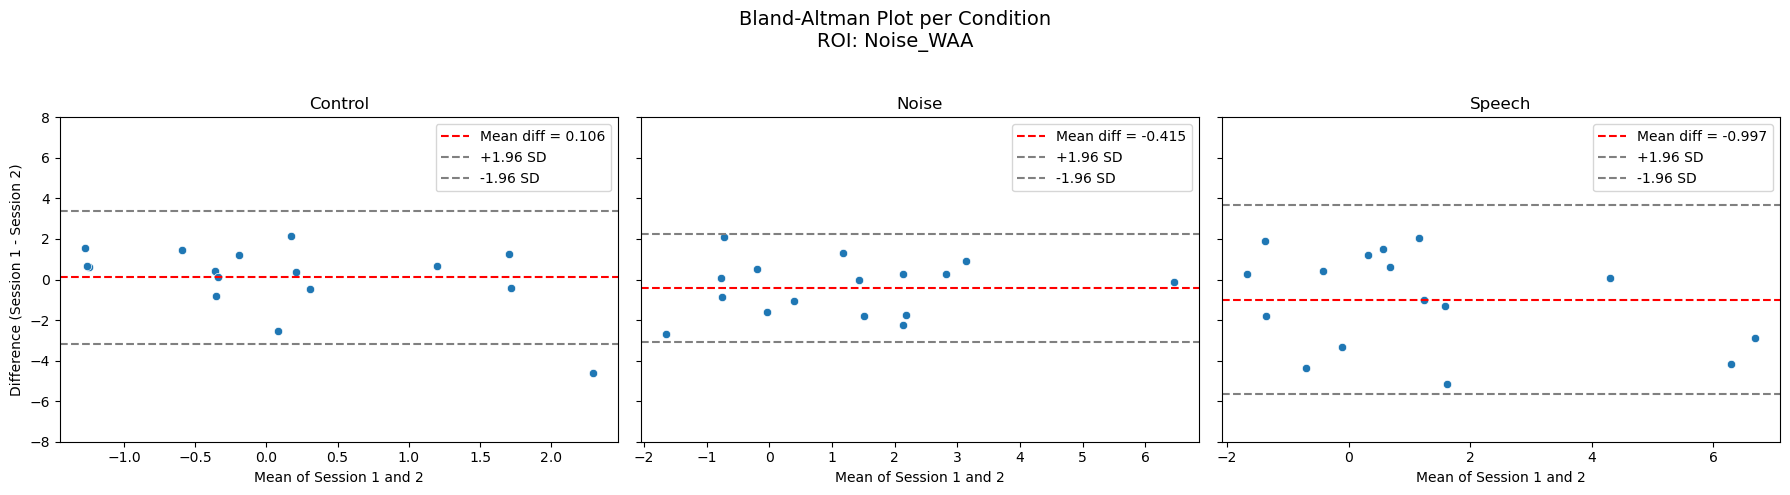

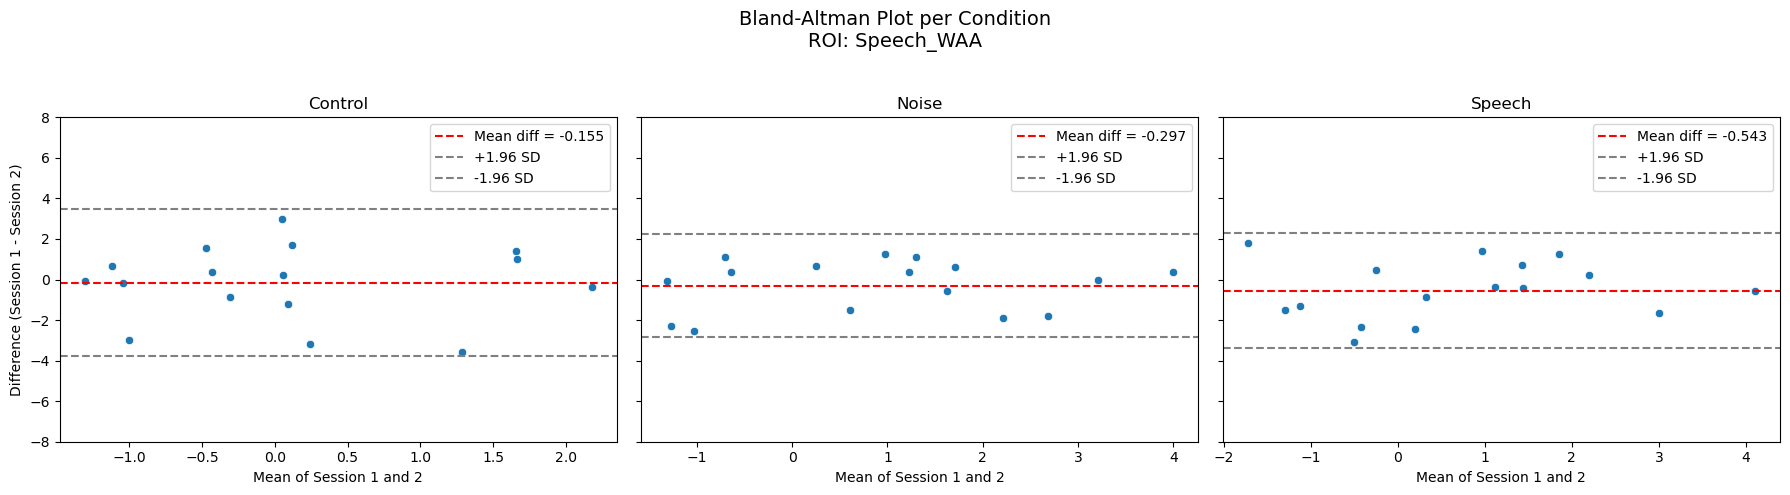

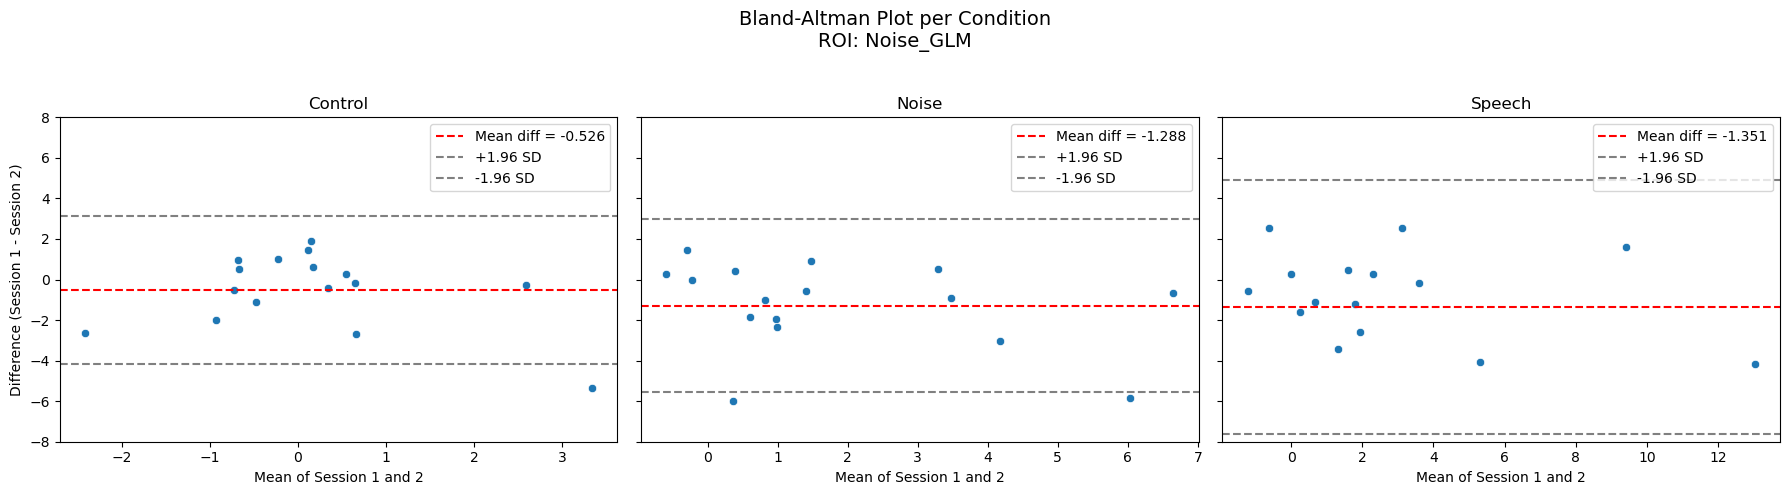

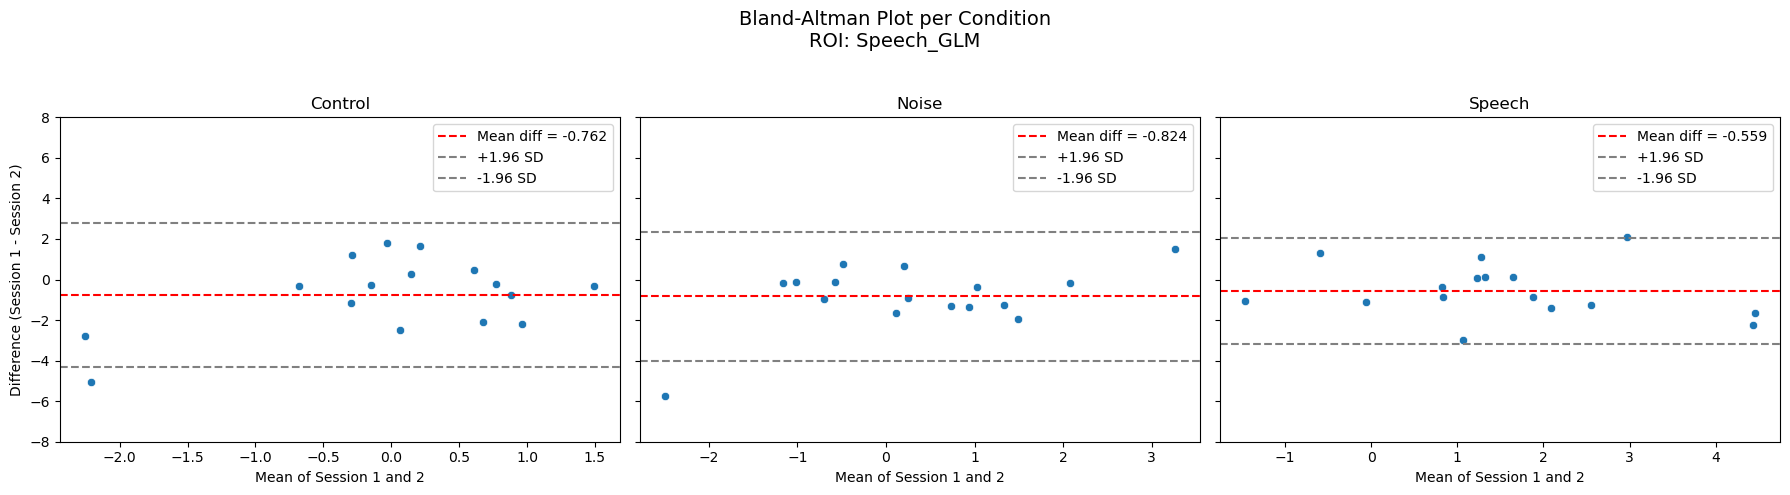

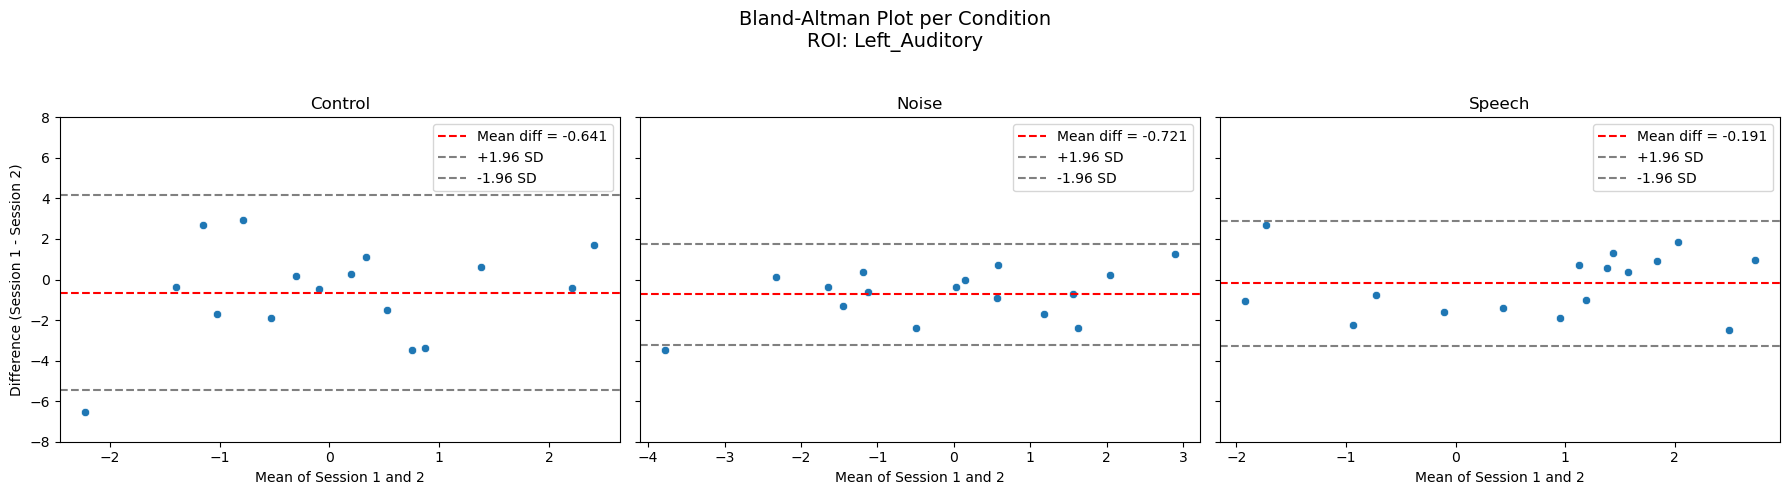

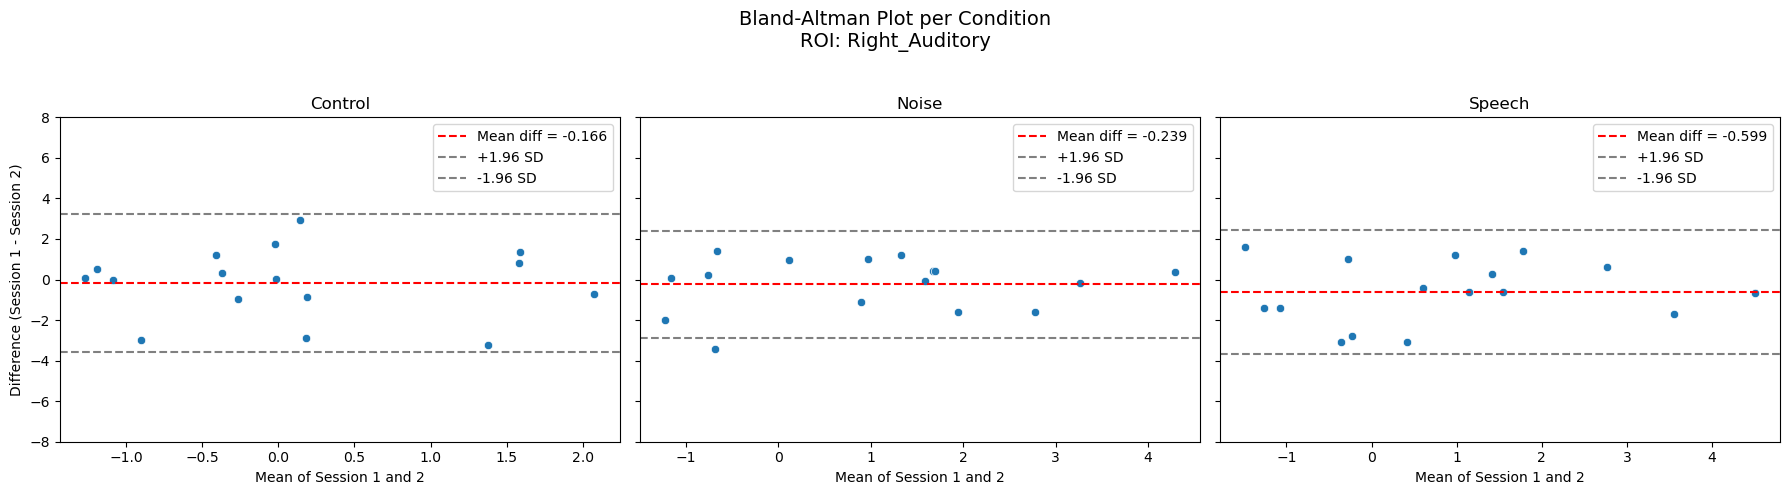

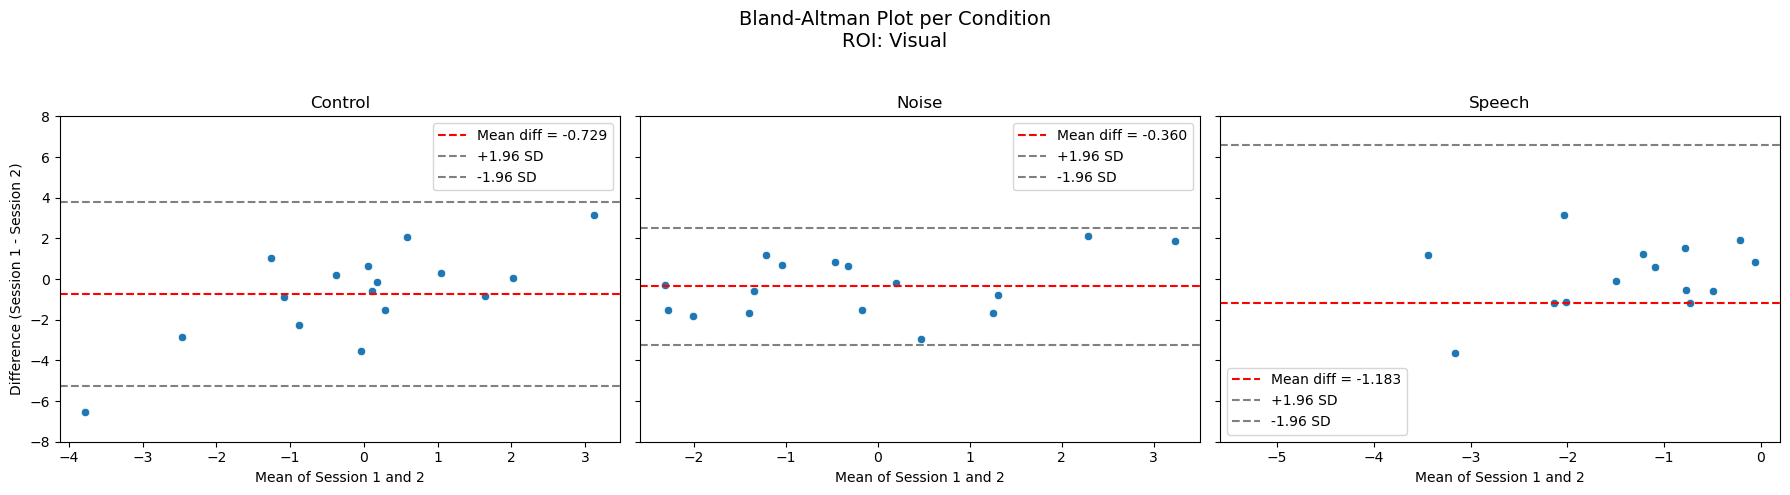

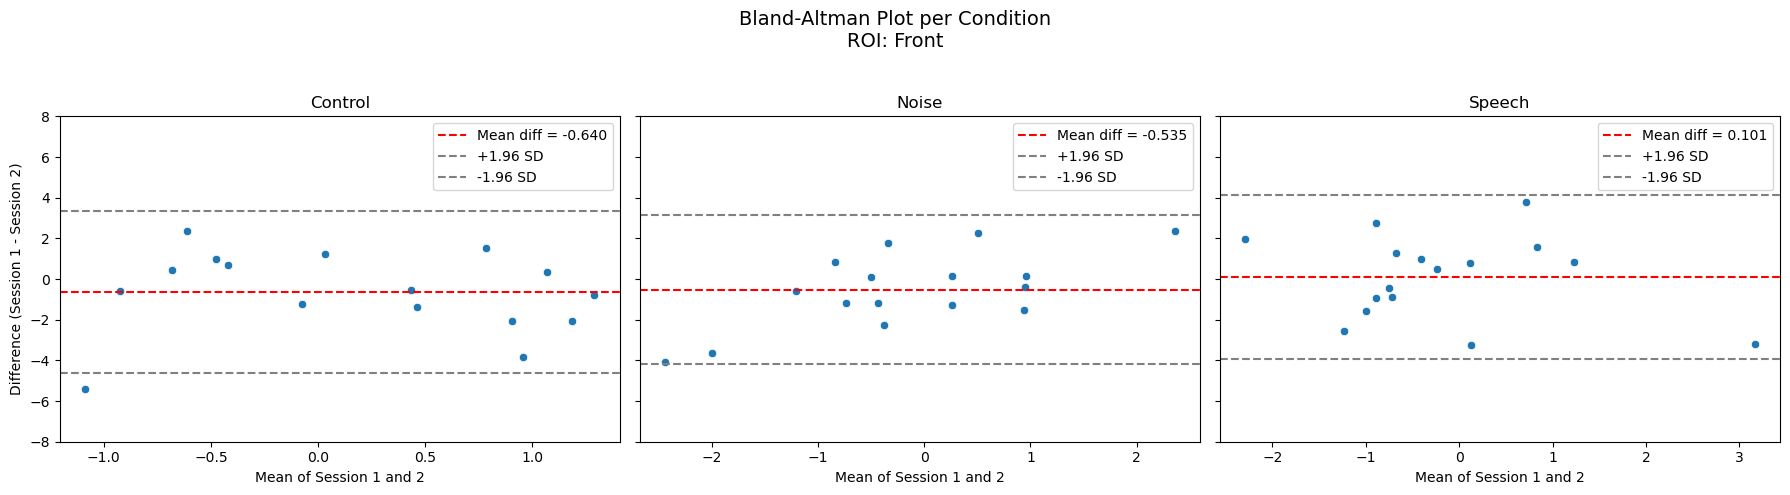

In [88]:
# Get unique experimental conditions
conditions = df_combined["Condition"].unique()
df_combined["session"] = df_combined["session"].astype(str).str.zfill(2)

# --- Bland-Altman plots per ROI and condition ---
for roi_name, optodes in rois.items():
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5), sharey=True)
    if len(conditions) == 1:
        axes = [axes]  # Ensure iterable if only one condition

    for ax, condition in zip(axes, conditions):
        # Filter data for current ROI and condition
        subset = df_combined[
            (df_combined["Optode"].isin(optodes)) & 
            (df_combined["Condition"] == condition)
        ]

        # Average over optodes for each subject and session
        mean_vals = subset.groupby(["Subject", "session"])["theta"].mean().reset_index()

        # Pivot so each subject has session 01 and 02 as columns
        pivot = mean_vals.pivot(index="Subject", columns="session", values="theta").dropna()

        if pivot.shape[0] < 2:
            ax.set_title(f'{condition}\nNot enough data')
            ax.axis('off')
            continue

        # Bland-Altman calculations
        session1 = pivot["01"]
        session2 = pivot["02"]
        avg = (session1 + session2) / 2
        diff = session1 - session2
        mean_diff = diff.mean()
        std_diff = diff.std()

        # Plot
        sns.scatterplot(x=avg, y=diff, ax=ax)
        ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.3f}')
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
        ax.set_title(f'{condition}')
        ax.set_xlabel('Mean of Session 1 and 2')
        if ax == axes[0]:
            ax.set_ylabel('Difference (Session 1 - Session 2)')
            ax.set_ylim(-8, 8)
        else:
            ax.set_ylabel('')
        ax.legend()

    plt.suptitle(f'Bland-Altman Plot per Condition\nROI: {roi_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
